# Constructing a Mapper graph using T0 scores for GMM

Authors: Erik Amezquita and Kathleen Storey
Date: 2/9/2023

This code uses T0 scores for Gaussian mixture models describing RNA-seq data for lung tumor and healthy subjects, and constructs a Mapper graph. It saves an image of the graph and matrices storing node and edge information, to be used in to compute the Heat Kernel Signature. 

## Input
- A CSV file containing the T0 scores for each gene expression subject

## Output
- A .png image of the Mapper graph
- CSV files 


In [50]:
# Load relevant packages
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy.spatial.distance as distance
import pandas as pd
import glob
import os
import math
import importlib
import matplotlib
import matplotlib.pyplot as plt
import colorsys
import mapper_tumor_utils as tumor
importlib.reload(tumor)
import gudhi as gd
import statmapper as stm
from sklearn_tda import MapperComplex

In [8]:
# Load data
# specify the cancer type and data type (T0, fpkm, etc.):
cancer_type = 'Lung'
data_type = 'T0'

# Enter path for the folder containing your data:
src = '/Users/storeyk/Documents/Research/Lung_Tumor_TDA/'
if data_type == 'T0':
    t0_scores = pd.read_csv(src + 'data/' + cancer_type + '_T0.csv')
    t0_scores = t0_scores.set_index('Hugo_Symbol')
elif data_type == 'fpkm':
    t0_scores = pd.read_csv(src + 'data/' + cancer_type + '_FPKM.csv')
    t0_scores = t0_scores.set_index('Hugo_Symbol')
    
t0_scores.sort_index(axis=1, inplace=True)

In [9]:
# Label tumor data vs. healthy data
labels = []

for person in t0_scores.columns:
    labels.append(person.split('-')[0] )

labels_int = np.array([1 if label == 'TCGA' else 0 for label in labels], dtype='uint8')

tumor_t0 = t0_scores.iloc[:, labels_int.astype(bool)]
health_t0 = t0_scores.iloc[:, ~labels_int.astype(bool)]
health_mean = health_t0.apply(np.mean, axis=1)
centered = t0_scores.sub(health_mean, axis='index')
col_diff = tumor_t0.sub(health_mean, axis='index')

In [11]:
# Compute the pairwise correlation between subjects
corr_t0, vals_t0 = tumor.explore_correlation(t0_scores)

In [16]:
# Create the Mapper graph

data = np.array(t0_scores).T
data = np.nan_to_num(data)

# Choose filter function values
# filter function type (default = mean correlation):
val_ind = 1
# clustering scale parameter (epsilon):
eps = 600
# number of bins (b):
b = 80
# percent overlap between bins (p):
p = 0.5

if val_ind==0:
    filt_type="mincorr"
elif val_ind==1:
    filt_type="meancorr"
elif val_ind==2:
    filt_type="maxcorr"
elif val_ind==3:
    filt_type="diffcorr" 
    

params = {"filters": vals_t0[val_ind][:,np.newaxis], "filter_bnds": np.array([[np.nan,np.nan]]), 
          "colors": labels_int[:,np.newaxis], 
          "resolutions": np.array([b]), "gains": np.array([p]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None,linkage='single',distance_threshold=eps),
          "mask": 2}

M = MapperComplex(**params).fit(data)

In [17]:
# Node information
G = stm.mapper2networkx(M)
subjects = 0
sett = set()

for node in G.nodes:
    subjects += M.node_info_[node]['size']
    sett = sett | set(M.node_info_[node]['indices'])

num_nodes=len(G.nodes)
print('Number of nodes: ', num_nodes)
print('Total distinct subjects', len(sett))

Number of nodes:  56
Total distinct subjects 807


In [18]:
# Node intersection information
intersections = []

for edge in G.edges():
    subj0 = set(M.node_info_[edge[0]]['indices'])
    subj1 = set(M.node_info_[edge[1]]['indices'])
    intersection = subj0 & subj1
    intersections.append(len(intersection))
intersections = np.array(intersections)  

In [20]:
# Save a matrix showing which subjects are in each node (subj vs node index)

subj_node_mat = np.zeros((t0_scores.shape[1], max(G.nodes)+1))

for node in G.nodes:
    node_list = M.node_info_[node]['indices']
    for subj in node_list:
        subj_node_mat[subj,node]=1
    
    
# save matrix to a .csv file
np.savetxt(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_r{}_g{}_subj_node_mat.csv'
               .format(eps,params['resolutions'][0], int(100*params['gains'][0])), subj_node_mat, fmt='%f', delimiter=",") 

In [93]:
# Create matrices to store node and edge information
# diagonal matrix with the proportion of malignant cells in each node:
prop_mat = np.zeros((num_nodes, num_nodes))
# matrix with number of overlapping cells between nodes (diag=number of cells in node):
edge_mat = np.zeros((num_nodes, num_nodes))

node_ind=0
for node in G.nodes:
    M.node_info_[node]['index']=node_ind
    #store prop of malignant cells in diagonal entry
    prop_mat[node_ind,node_ind] = M.node_info_[node]["colors"][0]
    edge_mat[node_ind,node_ind] = M.node_info_[node]['size']    
    node_ind +=1
    
for edge in G.edges():
    subj0 = set(M.node_info_[edge[0]]['indices'])
    subj1 = set(M.node_info_[edge[1]]['indices'])
    intersection = subj0 & subj1
    edge_mat[M.node_info_[edge[0]]['index'], M.node_info_[edge[1]]['index']] = len(intersection)
    edge_mat[M.node_info_[edge[1]]['index'], M.node_info_[edge[0]]['index']] = len(intersection)
    
# save the matrices to .csv files

np.savetxt(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_r{}_g{}_prop_mat.csv'
           .format(eps,params['resolutions'][0], int(100*params['gains'][0])), prop_mat, fmt='%f', delimiter=",") 
np.savetxt(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_r{}_g{}_edge_mat.csv'
           .format(eps,params['resolutions'][0], int(100*params['gains'][0])), edge_mat, fmt='%d', delimiter=",") 




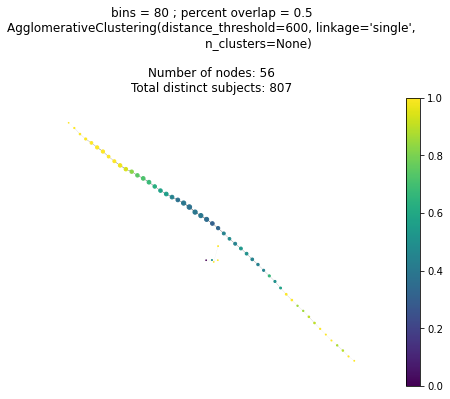

In [49]:
# Draw and save the Mapper graph 
graph=nx.draw(G, pos=nx.kamada_kawai_layout(G), 
        node_color=[M.node_info_[node]["colors"][0] for node in G.nodes()],
        node_size=[0.25*M.node_info_[node]['size'] for node in G.nodes()],
        linewidths=1,
        width = 0.01*intersections,
        node_shape='o',
        font_size=12)
vmin = min(M.node_info_[node]["colors"][0] for node in G.nodes())
vmax = max(M.node_info_[node]["colors"][0] for node in G.nodes())
cmap = [M.node_info_[node]["colors"][0] for node in G.nodes()]
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)


plt.title('bins = {} ; percent overlap = {}\n{}\n\nNumber of nodes: {}\nTotal distinct subjects: {}'
          .format(params['resolutions'][0], params['gains'][0], params['clustering'],len(G.nodes), len(sett)))


plt.savefig(src + 'data_viz/' + cancer_type + '/Mapper/' + cancer_type + '_' + data_type +'_' + filt_type + '_eps{}_b{}_p{}.png'
           .format(eps,params['resolutions'][0], int(100*params['gains'][0])), 
           dpi=150, format='png', bbox_inches='tight')
